**goal for this script is to calculate fundamental KPI scores and to deploy a neuronal network predicting revenue**
- Does the script calculate fundamental KPI scores for customers and products?
- Does the revenue prediction use a neuronal network?

# Customer lifetime value (CLV) can help to answer the most important questions about sales:

- How to Identify the most profitable customers?
- How can a company offer the best product to the right customer?
- How to approach profitable customers?
- Determine the characteristics of most valuable customer relationships and seek out customers with similar traits
- Predict future purchases and profits per customer
- Deliver unique segment-specific marketing Treatments
- Forecast customer satisfaction
- Innovate and optimize marketing tools, tactics and channels
- Adjust communication campaigns and messages
- Cross-sell and up-sell based on individual patterns of buying

In [1]:
from datetime import date
import pandas as pd
import sqlite3
import lifetimes
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Connect Data Sources
conn = sqlite3.connect('northwind.db')
orders = pd.read_sql_query("select * from Orders;", conn)
order_detail = pd.read_sql_query("select * from OrderDetails;", conn)
customer = pd.read_sql_query("select * from Customers;", conn)
products = pd.read_sql_query("select * from Products;", conn)
categories = pd.read_sql_query("select * from Categories;", conn)

order_detail.head()

,OrderDetailID,OrderID,ProductID,UnitPrice,Quantity,Discount
0,1,10248,11,14.0,12,0.0
1,2,10248,42,9.8,10,0.0
2,3,10248,72,34.8,5,0.0
3,4,10249,14,18.6,9,0.0
4,5,10249,51,42.4,40,0.0


In [2]:
# Joining Tables to MasterDataSet
mds = pd.merge(orders, order_detail, on='OrderID', how='left')
mds2 = pd.merge(mds, customer, on='CustomerID', how='left')
mds2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2156 entries, 0 to 2155
Data columns (total 29 columns):
OrderID           2156 non-null int64
CustomerID        2156 non-null object
EmployeeID        2156 non-null int64
OrderDate         2156 non-null object
RequiredDate      2156 non-null object
ShippedDate       2083 non-null object
ShipVia           2156 non-null int64
Freight           2156 non-null float64
ShipName          2156 non-null object
ShipAddress       2156 non-null object
ShipCity          2156 non-null object
ShipRegion        856 non-null object
ShipPostalCode    2156 non-null object
ShipCountry       2156 non-null object
OrderDetailID     2155 non-null float64
ProductID         2155 non-null float64
UnitPrice         2155 non-null float64
Quantity          2155 non-null float64
Discount          2155 non-null float64
CompanyName       2156 non-null object
ContactName       2156 non-null object
ContactTitle      2156 non-null object
Address           2156 non-null o

In [3]:
#Calculate total purchase aga revenue
mds2['TotalPurchase'] = (mds2['Quantity'] * mds2['UnitPrice']) - (mds2['Quantity'] * mds2['UnitPrice']* mds2['Discount'])
mds2['OrderDate'] = pd.to_datetime(mds2['OrderDate'])
mds2.groupby('CustomerID').mean()

,OrderID,EmployeeID,ShipVia,Freight,OrderDetailID,ProductID,UnitPrice,Quantity,Discount,TotalPurchase
CustomerID,,,,,,,,,,
ALFKI,10801.750000,3.333333,1.416667,34.966667,1446.000000,46.166667,26.737500,14.500000,0.087500,356.083333
ANATR,10695.400000,4.200000,2.400000,30.659000,1171.400000,40.200000,21.505000,6.300000,0.000000,140.295000
ANTON,10608.823529,4.176471,1.941176,39.252353,953.941176,38.235294,21.719412,21.117647,0.058824,413.175147
AROUT,10680.133333,4.200000,2.233333,48.238000,1136.600000,45.700000,19.176667,21.666667,0.023333,446.355000
BERGS,10625.653846,4.173077,2.019231,92.984231,994.538462,39.019231,27.416346,19.250000,0.057692,479.376490
BLAUS,10779.357143,6.928571,2.428571,25.100714,1385.500000,40.357143,24.789286,10.000000,0.000000,231.414286
BLONP,10475.923077,4.692308,1.884615,76.153846,606.153846,43.884615,32.644231,25.615385,0.028846,712.849231
BOLID,10591.666667,4.833333,1.833333,74.016667,897.833333,39.000000,34.865000,31.666667,0.116667,705.475000
BONAP,10696.500000,4.454545,1.909091,89.832955,1175.500000,36.340909,24.123864,22.272727,0.072727,499.164830


In [4]:
# Calculate basic RFM Score manually
#T = Zeit zwischen der ersten Bestellung eines Kunden und dem Ende des Merkmalzeitraums

customer_detail=mds2.groupby('CustomerID').agg({'OrderDate': lambda date: (date.max() - date.min()).days,
                                        'OrderID': lambda num: len(np.unique(num)),
                                        'Quantity': lambda quant: quant.sum(),
                                        'TotalPurchase': lambda price: price.sum()})
customer_detail.columns=['recency','frequency','num_units','monetary']
customer_detail['frequency'] = customer_detail['frequency'].apply(lambda x: x-1) # Nummer minus 1
customer_detail['T'] = (mds2['OrderDate'].max()- mds2.groupby('CustomerID')['OrderDate'].min()).dt.days
customer_detail['avg_order_value']=customer_detail['monetary']/customer_detail['frequency']
customer_detail.head(20)

,recency,frequency,num_units,monetary,T,avg_order_value
CustomerID,,,,,,
ALFKI,227,5,174.0,4273.0000,254,854.600000
ANATR,532,3,63.0,1402.9500,595,467.650000
ANTON,427,6,359.0,7023.9775,525,1170.662917
AROUT,511,12,650.0,13390.6500,537,1115.887500
BERGS,569,17,1001.0,24927.5775,632,1466.328088
BLAUS,385,6,140.0,3239.8000,392,539.966667
BLONP,536,10,666.0,18534.0800,650,1853.408000
BOLID,530,2,190.0,4232.8500,573,2116.425000
BONAP,567,16,980.0,21963.2525,567,1372.703281


In [5]:
# Zu Sicherheit die Programmierung des Backups
from lifetimes.utils import summary_data_from_transaction_data
backup = summary_data_from_transaction_data(mds2, 'CustomerID', 'OrderDate', observation_period_end='2018-05-06')

print(backup.head())

            frequency  recency      T
CustomerID                           
ALFKI             5.0    227.0  254.0
ANATR             3.0    532.0  595.0
ANTON             6.0    427.0  525.0
AROUT            12.0    511.0  537.0
BERGS            17.0    569.0  632.0


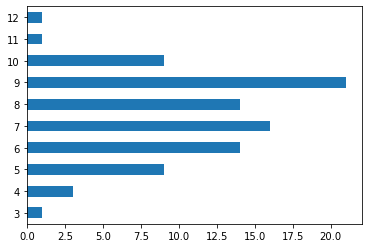

In [6]:
# Summarise into RFM-Score
customer_detail['r_quartile'] = pd.qcut(customer_detail['recency'], 4, ['1','2','3','4'])
customer_detail['f_quartile'] = pd.qcut(customer_detail['frequency'], 4, ['4','3','2','1'])
customer_detail['m_quartile'] = pd.qcut(customer_detail['monetary'], 4, ['4','3','2','1'])
customer_detail['RFM_Score'] = customer_detail.r_quartile.astype(str)+ customer_detail.f_quartile.astype(str) + customer_detail.m_quartile.astype(str)
customer_detail['profit']=customer_detail['monetary']*0.05
customer_detail= customer_detail.query('frequency > 0')
customer_detail['Total_Score'] = customer_detail.r_quartile.astype(int)+ customer_detail.f_quartile.astype(int) + customer_detail.m_quartile.astype(int)

CountStatus = pd.value_counts(customer_detail['Total_Score'].values, sort=False)
CountStatus.plot.barh()

# Get into Customer Lifetime Value

- The Customer Lifetime Value refers to past profits + expected no. of future transactions * expected profit per transaction

**Estimate future purchase frequency per customer**
- or in other words: the probability that a customer places a repeat purchase
- Pareto/NBD for estimating the number of future purchases a customer will make
- Beta Geometric/Negative Binomial Distribution (BG/NBD) model is an improvement of the Pareto/NBD model 

**Afterwards we estimate a customer’s average order value, to get the monetary involved**
- Gamma Gamma model estimates average order values 
- this model is used on top of the BG/NBD model to estimate the monetary value of transactions
- We can only rely on a customer’s past purchases and characterizing events, like website visits, reviews, etc.

In [7]:
#https://lifetimes.readthedocs.io/en/master/lifetimes.html
from lifetimes import ModifiedBetaGeoFitter

mbgnbd = ModifiedBetaGeoFitter(penalizer_coef=0.001)
mbgnbd.fit(customer_detail['frequency'], customer_detail['recency'], customer_detail['T'], verbose=True, fit_method='Nelder-Mead')
mbgnbd.summary

Optimization terminated successfully.
         Current function value: -11.538034
         Iterations: 47
         Function evaluations: 49
         Gradient evaluations: 49


,coef,se(coef),lower 95% bound,upper 95% bound
r,3.924127e+00,7.802456e-01,2.394846e+00,5.453408e+00
alpha,2.573613e+02,5.375690e+01,1.519978e+02,3.627249e+02
a,2.202724e-22,1.299103e-14,-2.546242e-14,2.546242e-14
b,6.819701e-05,1.676005e+00,-3.284902e+00,3.285039e+00


In [8]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0001)
bgf.fit(customer_detail['frequency'], customer_detail['recency'], customer_detail['T'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,4.446793e+00,1.007154,2.472771,6.420815
alpha,2.915832e+02,68.373525,157.571087,425.595307
a,5.789183e-20,NaN,NaN,NaN
b,1.104983e-09,NaN,NaN,NaN


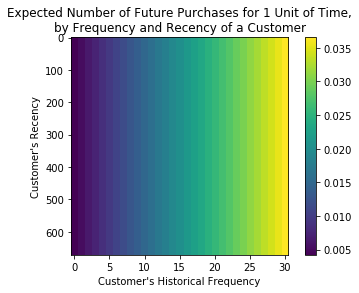

In [9]:
#from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_frequency_recency_matrix
plot_frequency_recency_matrix(mbgnbd)

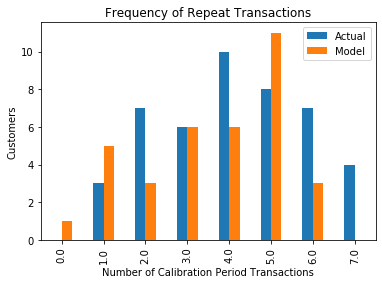

In [10]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [11]:
t = 90 # days to predict in the future 
customer_detail['pred_90d_bgf'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                                      customer_detail['frequency'], 
                                                                                      customer_detail['recency'], 
                                                                                      customer_detail['T'])
customer_detail.sort_values(by='pred_90d_bgf').tail(5)

,recency,frequency,num_units,monetary,T,avg_order_value,r_quartile,f_quartile,m_quartile,RFM_Score,profit,Total_Score,pred_90d_bgf
CustomerID,,,,,,,,,,,,,
BONAP,567,16,980.0,21963.2525,567,1372.703281,3,1,1,311,1098.162625,5,2.143312
HUNGO,602,18,1684.0,49979.9050,608,2776.661389,3,1,1,311,2498.995250,5,2.245719
QUICK,617,27,3961.0,110277.3050,639,4084.344630,4,1,1,411,5513.865250,6,3.041331
ERNSH,657,29,4543.0,104874.9785,658,3616.378569,4,1,1,411,5243.748925,6,3.170034
SAVEA,570,30,4958.0,104361.9500,575,3478.731667,3,1,1,311,5218.097500,5,3.577512


In [12]:
#highest expected purchases in the next period

customer_detail['pred_90d_mbgnbd'] = mbgnbd.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                                      customer_detail['frequency'], 
                                                                                      customer_detail['recency'], 
                                                                                      customer_detail['T'])
customer_detail.head()

,recency,frequency,num_units,monetary,T,avg_order_value,r_quartile,f_quartile,m_quartile,RFM_Score,profit,Total_Score,pred_90d_bgf,pred_90d_mbgnbd
CustomerID,,,,,,,,,,,,,,
ALFKI,227,5,174.0,4273.0000,254,854.600000,1,3,3,133,213.650000,7,1.558353,1.570653
ANATR,532,3,63.0,1402.9500,595,467.650000,2,4,4,244,70.147500,10,0.755949,0.731112
ANTON,427,6,359.0,7023.9775,525,1170.662917,1,3,3,133,351.198875,7,1.151397,1.141635
AROUT,511,12,650.0,13390.6500,537,1115.887500,2,1,2,212,669.532500,5,1.786437,1.804181
BERGS,569,17,1001.0,24927.5775,632,1466.328088,3,1,1,311,1246.378875,5,2.089916,2.117442


In [13]:
customer_detail['p_alive'] = mbgnbd.conditional_probability_alive(customer_detail['frequency'], customer_detail['recency'], customer_detail['T'])
customer_detail.head()

,recency,frequency,num_units,monetary,T,avg_order_value,r_quartile,f_quartile,m_quartile,RFM_Score,profit,Total_Score,pred_90d_bgf,pred_90d_mbgnbd,p_alive
CustomerID,,,,,,,,,,,,,,,
ALFKI,227,5,174.0,4273.0000,254,854.600000,1,3,3,133,213.650000,7,1.558353,1.570653,1.0
ANATR,532,3,63.0,1402.9500,595,467.650000,2,4,4,244,70.147500,10,0.755949,0.731112,1.0
ANTON,427,6,359.0,7023.9775,525,1170.662917,1,3,3,133,351.198875,7,1.151397,1.141635,1.0
AROUT,511,12,650.0,13390.6500,537,1115.887500,2,1,2,212,669.532500,5,1.786437,1.804181,1.0
BERGS,569,17,1001.0,24927.5775,632,1466.328088,3,1,1,311,1246.378875,5,2.089916,2.117442,1.0


In [14]:
#The Gamma-Gamma model assumes that there is no relationship between the monetary value and the purchase frequency
customer_detail[['avg_order_value','frequency']].corr()

,avg_order_value,frequency
avg_order_value,1.00000,0.67721
frequency,0.67721,1.00000


In [15]:
#It is used to estimate the average monetary value of customer transactions
from lifetimes import GammaGammaFitter

gg = GammaGammaFitter(penalizer_coef = 0.001)
gg.fit(customer_detail['frequency'], customer_detail['avg_order_value'],verbose=True)

print(gg.conditional_expected_average_profit(
        customer_detail['frequency'],
        customer_detail['avg_order_value']
    ).head(10))

Optimization terminated successfully.
         Current function value: 9.033673
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
CustomerID
ALFKI     863.842758
ANATR     478.048052
ANTON    1180.419358
AROUT    1120.571556
BERGS    1470.435704
BLAUS     545.604037
BLONP    1861.915042
BOLID    2164.857231
BONAP    1376.839883
BOTTM    1605.900256
dtype: float64


In [16]:
customer_detail['clv']=gg.customer_lifetime_value(
    mbgnbd,
    customer_detail['frequency'],
    customer_detail['recency'],
    customer_detail['T'],
    customer_detail['avg_order_value'],
    time=t,
    discount_rate=0
).astype(int)
customer_detail[['frequency', 'pred_90d_bgf', 'monetary', 'avg_order_value', 'clv']].head()

,frequency,pred_90d_bgf,monetary,avg_order_value,clv
CustomerID,,,,,
ALFKI,5,1.558353,4273.0000,854.600000,40703
ANATR,3,0.755949,1402.9500,467.650000,10485
ANTON,6,1.151397,7023.9775,1170.662917,40428
AROUT,12,1.786437,13390.6500,1115.887500,60651
BERGS,17,2.089916,24927.5775,1466.328088,93406


In [17]:
customer_detail['exp_orders'] = (customer_detail['clv']/gg.conditional_expected_average_profit(customer_detail['frequency'], customer_detail['avg_order_value'])).astype(int)
customer_detail['potential']=100-((100/customer_detail['clv'])*customer_detail['monetary'])
customer_detail[['frequency', 'exp_orders', 'monetary', 'avg_order_value', 'clv', 'potential']].head(10)

,frequency,exp_orders,monetary,avg_order_value,clv,potential
CustomerID,,,,,,
ALFKI,5,47,4273.0000,854.600000,40703,89.502002
ANATR,3,21,1402.9500,467.650000,10485,86.619456
ANTON,6,34,7023.9775,1170.662917,40428,82.625958
AROUT,12,54,13390.6500,1115.887500,60651,77.921798
BERGS,17,63,24927.5775,1466.328088,93406,73.312659
BLAUS,6,41,3239.8000,539.966667,22513,85.609204
BLONP,10,41,18534.0800,1853.408000,77145,75.975008
BOLID,2,19,4232.8500,2116.425000,41701,89.849524
BONAP,16,65,21963.2525,1372.703281,89848,75.555101


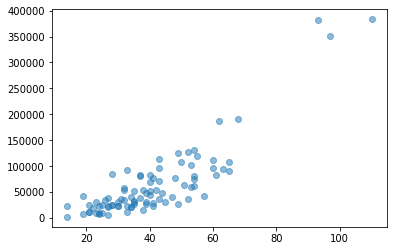

In [18]:
#Da es sich um ein komplexes Modell handelt, ist der Zusammenhang nicht linear
plt.scatter(customer_detail['exp_orders'], customer_detail['clv'], alpha=0.5)
plt.show()

In [19]:
# Currently the dataset provides 47 attributes to predict the revenue
mds3 = pd.merge(mds2, customer_detail, on='CustomerID', how='left')
#mds3.shape
mds3.shape

(2156, 48)

# Calculating basic product sales KPIs
- Share of product category in sales
- product category growth (Compound Annual Growth Rates, also known as CAGR)
- price development (Exponential Moving Average (EMA),more weight to the recent prices)
- instead of categories we could use products, but categories give a better overview

In [26]:
prod_details=pd.merge(mds3[['OrderDate', 'ProductID', 'Quantity', 'TotalPurchase']], products, on='ProductID', how='left')
prod_details2 = pd.merge(prod_details, categories, on='CategoryID', how='left')
prod_details2['OrderYear'] = prod_details2['OrderDate'].dt.year
prod_details2.shape

(2156, 17)

In [21]:
# Es sollen lediglich die Produktkategorien ausgewertet werden - nicht die einzelnen Produkte
# Dies dient aktuell der Übersichtlichkeit

cat_details = prod_details2.groupby('CategoryName')['OrderYear'].value_counts().unstack()
print(prod_details2['OrderDate'].max())
d1 = date(2018, 1, 1)
cat_details[2018] = cat_details[2018].apply(lambda x: x*1.58333) #Extrapolation bis zu, Jahresende
print(cat_details)

2018-05-06 00:00:00
OrderYear       2016  2017       2018
CategoryName                         
Beverages         78   176  237.49950
Condiments        39   106  112.41643
Confections       59   171  164.66632
Dairy Products    81   182  163.08299
Grains/Cereals    29   105   98.16646
Meat/Poultry      37    90   72.83318
Produce           26    67   68.08319
Seafood           56   162  177.33296


In [22]:
cat_details2 =cat_details.pct_change(axis='columns')
cat_details2

OrderYear,2016,2017,2018
CategoryName,,,
Beverages,NaN,1.256410,0.349429
Condiments,NaN,1.717949,0.060532
Confections,NaN,1.898305,-0.037039
Dairy Products,NaN,1.246914,-0.103940
Grains/Cereals,NaN,2.620690,-0.065081
Meat/Poultry,NaN,1.432432,-0.190742
Produce,NaN,1.576923,0.016167
Seafood,NaN,1.892857,0.094648


In [24]:
cat_details2['avg_growth'] =cat_details2[2017]*0.2+cat_details2[2018]*0.8
#cat_details.ewm(com=0.5, axis='columns').mean()
cat_details2

OrderYear,2016,2017,2018,avg_growth
CategoryName,,,,
Beverages,NaN,1.256410,0.349429,0.530825
Condiments,NaN,1.717949,0.060532,0.392016
Confections,NaN,1.898305,-0.037039,0.350030
Dairy Products,NaN,1.246914,-0.103940,0.166231
Grains/Cereals,NaN,2.620690,-0.065081,0.472073
Meat/Poultry,NaN,1.432432,-0.190742,0.133893
Produce,NaN,1.576923,0.016167,0.328318
Seafood,NaN,1.892857,0.094648,0.454290


In [25]:
cat_details2 = cat_details2.drop([2016], axis=1)
cat_details2 = cat_details2.rename(columns={2017: 'growth_2017', 2018: 'growth_2018'})
cat_details2

OrderYear,growth_2017,growth_2018,avg_growth
CategoryName,,,
Beverages,1.256410,0.349429,0.530825
Condiments,1.717949,0.060532,0.392016
Confections,1.898305,-0.037039,0.350030
Dairy Products,1.246914,-0.103940,0.166231
Grains/Cereals,2.620690,-0.065081,0.472073
Meat/Poultry,1.432432,-0.190742,0.133893
Produce,1.576923,0.016167,0.328318
Seafood,1.892857,0.094648,0.454290


In [34]:
prod_details3 = pd.merge(prod_details2, cat_details2, how = 'inner', left_on=['CategoryName'], right_on=[cat_details2.index])
prod_details4 = prod_details3.groupby('ProductID').agg(['max'])


,ProductName,SupplierID,CategoryID,CategoryName,QuantityPerUnit,UnitsInStock,Discontinued,growth_2017,growth_2018,avg_growth
,max,max,max,max,max,max,max,max,max,max
ProductID,,,,,,,,,,
1.0,Chai,1.0,1.0,Beverages,10 boxes x 20 bags,39.0,0.0,1.256410,0.349429,0.530825
2.0,Chang,1.0,1.0,Beverages,24 - 12 oz bottles,17.0,0.0,1.256410,0.349429,0.530825
3.0,Aniseed Syrup,1.0,2.0,Condiments,12 - 550 ml bottles,13.0,0.0,1.717949,0.060532,0.392016
4.0,Chef Anton's Cajun Seasoning,2.0,2.0,Condiments,48 - 6 oz jars,53.0,0.0,1.717949,0.060532,0.392016
5.0,Chef Anton's Gumbo Mix,2.0,2.0,Condiments,36 boxes,0.0,1.0,1.717949,0.060532,0.392016
6.0,Grandma's Boysenberry Spread,3.0,2.0,Condiments,12 - 8 oz jars,120.0,0.0,1.717949,0.060532,0.392016
7.0,Uncle Bob's Organic Dried Pears,3.0,7.0,Produce,12 - 1 lb pkgs.,15.0,0.0,1.576923,0.016167,0.328318
8.0,Northwoods Cranberry Sauce,3.0,2.0,Condiments,12 - 12 oz jars,6.0,0.0,1.717949,0.060532,0.392016


In [36]:
#Thanks to Feature Engineering we receive 57 Attributes, compared to 28 from beginning
mds4 = pd.merge(mds3, prod_details4[['ProductName', 'SupplierID', 'CategoryID', 'CategoryName', 'QuantityPerUnit', 'UnitsInStock', 'Discontinued', 'growth_2017', 'growth_2018', 'avg_growth']], how='left', on='ProductID')
mds4.shape

(2156, 58)

In [ ]:
mds4.isnull().sum()

# Data-Preparation for the Neuronal Network

In [ ]:
corr_matrix = mds4.corr()
corr_matrix['TotalPurchase_y'].sort_values(ascending=False)

In [ ]:
#Categorical Attrributes doesnt work for a neuronal network
#Therefore we have to convert into numerical values
mds4= mds4.drop(['RequiredDate','ShippedDate', 'Phone', 'Fax'], axis=1)
maske=list(mds4.select_dtypes(include=[object]))
mds4[maske].to_excel("test.xlsx", sheet_name='Sheet_name_1', engine='xlsxwriter')

In [ ]:
#mds4['ShipRegion'].value_counts().idxmax()
for col in mds4.columns:
    col.value_counts().idxmax()

In [ ]:


def replace(x):
   return pd.replace(None, mds4['ShipRegion'] * 2

mds4.apply(pd.replace(None, mds4['ShipRegion']))

mds4.apply(.replace(None, mds4[column].value_counts().idxmax())
mds4.isnull().sum()

data[['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']].apply(pd.to_numeric) 

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
mds4[maske] = mds4[maske].apply(lambda col: le.fit_transform(col))
mds4